In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
inspector = inspect(engine)

In [8]:
inspector.get_table_names()

['measurement', 'station']

In [11]:
for table in inspector.get_table_names():
    print(table)
    for col in inspector.get_columns(table):
        print(f'\t{col["name"]}: {col["type"]}')

measurement
	id: INTEGER
	station: TEXT
	date: TEXT
	prcp: FLOAT
	tobs: FLOAT
station
	id: INTEGER
	station: TEXT
	name: TEXT
	latitude: FLOAT
	longitude: FLOAT
	elevation: FLOAT


In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

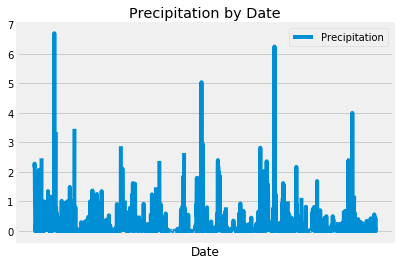

In [146]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(func.max(Measurement.date)).all()[0][0]
# Calculate the date 1 year ago from the last data point in the database
max_datetime = dt.datetime.strptime(max_date, '%Y-%m-%d').date()
prev_year_date = dt.date(max_datetime.year - 1, max_datetime.month, max_datetime.day)
# Perform a query to retrieve the data and precipitation scores
# Retrieved average precipitation across all weather stations
last_12_prcp = session.query(Measurement.date, func.avg(Measurement.prcp)).filter(Measurement.date > prev_year_date)\
.group_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
last_12_prcp_df = pd.DataFrame(last_12, columns = ['Date','Precipitation']).set_index('Date')
# Sort the dataframe by date
last_12_prcp_df_sorted = last_12_df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
ax = last_12_prcp_df_sorted.plot()
ax.set_title('Precipitation by Date')
ax.set_xticks([])
plt.show()

In [64]:
max_date

'2017-08-23'

![precipitation](Images/precipitation.png)

In [40]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_df_sorted.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [46]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).distinct().count()

9

In [45]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
.order_by((func.count(Measurement.station)).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [54]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
max_id = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
.order_by((func.count(Measurement.station)).desc()).first()[0]

summ_stats = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == max_id).group_by(Measurement.station).all()

pd.DataFrame(summ_stats, columns = ['Station ID','Min Temp','Max Temp','Avg Temp'])

,Station ID,Min Temp,Max Temp,Avg Temp
0,USC00519281,54.0,85.0,71.663781


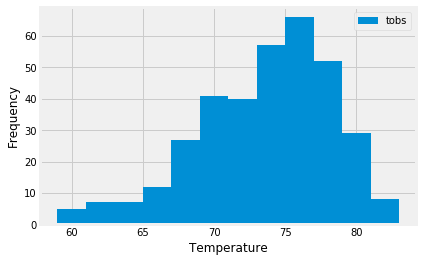

In [63]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_temp = list(np.ravel(session.query(Measurement.tobs).filter(Measurement.date > prev_year_date)\
.filter(Measurement.station == max_id).all()))
plt.hist(last_12_temp, bins = 12, label='tobs')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.legend()
plt.show()

![precipitation](Images/station-histogram.png)

In [66]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [94]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2016-10-07'
end_date = '2016-10-21'
trip_temps = pd.DataFrame(calc_temps(start_date,end_date), columns = ['Min Temp','Avg Temp','Max Temp'])\
.assign(PTP = lambda x: x['Max Temp'] - x['Min Temp'])
trip_temps

,Min Temp,Avg Temp,Max Temp,PTP
0,70.0,77.478723,82.0,12.0


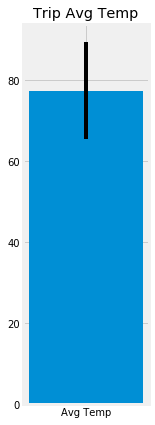

In [95]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2, 7))
plt.bar('Avg Temp', trip_temps['Avg Temp'], yerr = trip_temps['PTP'])
plt.title('Trip Avg Temp')
plt.show()

In [96]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,
              func.sum(Measurement.prcp)).filter(Station.station == Measurement.station)\
.filter(Measurement.date >= start_date).filter(Measurement.date <= end_date)\
.group_by(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation)\
.order_by(func.sum(Measurement.prcp).desc()).all()


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.76),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.49000000000000005),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.33999999999999997),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.15),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.13999999999999999),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.060000000000000005),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [111]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()[0]
    
daily_normals("01-01")

(62.0, 69.15384615384616, 77.0)

In [148]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
print(f'Start date: {start_date}')
print(f'End date: {end_date}')

# Use the start and end date to create a range of date strings in %m-%d format
date_range = list(pd.date_range(start_date,end_date).strftime('%m-%d'))

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norm_list = list(map(daily_normals, date_range))

Start date: 2016-10-07
End date: 2016-10-21


In [149]:
daily_norm_list

[(68.0, 75.6078431372549, 81.0),
 (66.0, 76.3265306122449, 86.0),
 (69.0, 76.11363636363636, 84.0),
 (69.0, 75.85416666666667, 83.0),
 (69.0, 76.57142857142857, 84.0),
 (65.0, 75.75510204081633, 82.0),
 (65.0, 75.98039215686275, 84.0),
 (67.0, 75.1923076923077, 82.0),
 (67.0, 75.63461538461539, 82.0),
 (67.0, 75.59183673469387, 81.0),
 (65.0, 75.07843137254902, 83.0),
 (65.0, 75.0, 83.0),
 (65.0, 73.24489795918367, 81.0),
 (67.0, 74.79629629629629, 82.0),
 (66.0, 74.96078431372548, 82.0)]

In [114]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norm_df = pd.DataFrame(daily_norm_list, columns = ['tmin','tavg','tmax'], index = date_range)
daily_norm_df

,tmin,tavg,tmax
10-07,68.0,75.607843,81.0
10-08,66.0,76.326531,86.0
10-09,69.0,76.113636,84.0
10-10,69.0,75.854167,83.0
10-11,69.0,76.571429,84.0
10-12,65.0,75.755102,82.0
10-13,65.0,75.980392,84.0
10-14,67.0,75.192308,82.0
10-15,67.0,75.634615,82.0
10-16,67.0,75.591837,81.0


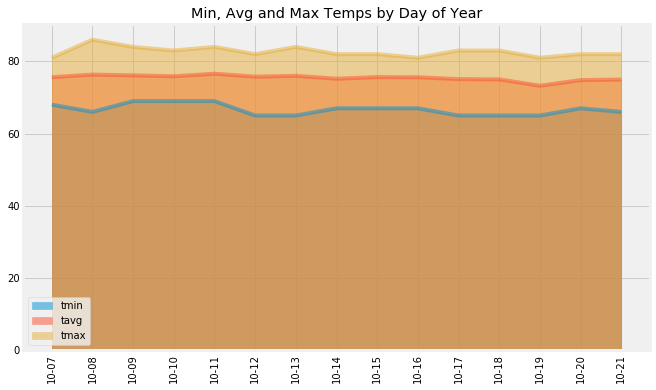

In [151]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norm_df.plot.area(stacked = False, figsize = (10,6))
plt.xticks(range(len(daily_norm_df)),daily_norm_df.index.values, rotation='vertical')
plt.title('Min, Avg and Max Temps by Day of Year')
plt.show()